In [1]:
import jax
import jax.numpy as jnp
from jax import jit, lax, random, vmap, grad

import numpy as np
import matplotlib.pyplot as plt

from functools import partial

In [2]:
def linear_quadratic_two_player(A, B1, B2, Q1, Q2, R11, R12, R21, R22, state_noise):
    """ Generator for linear state dynamics and quadratic costs. """
    print(A)
    n_state = A.shape[0]
    n_act1 = B1.shape[1]
    n_act2 = B2.shape[1]
    
    assert A.shape[0] == A.shape[1], "A must be square"
    assert B1.shape[0] == n_state and B2.shape[0] == n_state, "B1,B2 are in the wrong shape"
    assert R11.shape == (n_act1, n_act1), "R11 is in the wrong shape"
    assert R12.shape == (n_act2, n_act2), "R12 is in the wrong shape"
    assert R21.shape == (n_act1, n_act1), "R21 is in the wrong shape"
    assert R22.shape == (n_act2, n_act2), "R22 is in the wrong shape"
    print(n_state)
    assert Q1.shape == (n_state, n_state), "Q1 is in the wrong shape"
    assert Q2.shape == (n_state, n_state), "Q2 is in the wrong shape"
    assert state_noise >= 0
    
    K1 = jnp.zeros(B1.shape).T
    K2 = jnp.zeros(B2.shape).T
    
    def state_dynamics(state, key, policies=(K1,K2)):
        K1, K2 = policies
        act1, act2 = K1@state, K2@state

        noise = random.normal(key, (n_state,))
        state = A@state + B1@act1 + B2@act2 + state_noise**2*noise

        cost1 = state.T@Q1@state + act1.T@R11@act1 + act2.T@R12@act2
        cost2 = state.T@Q2@state + act1.T@R21@act1 + act2.T@R22@act2
        costs = (cost1, cost2)

        return state, dict(costs=costs, state=state)
    
    return state_dynamics

# Vector
n_state = 3
n_actions = 2

Is = np.eye(n_state)
Ia = np.eye(n_actions)
Isa = np.ones((n_state, n_actions))

sys3_coop_params = dict(A=0.3*Is, B1=Isa, B2=Isa,
                        Q1=Is, Q2=3*Is, R11=Ia, R12=Ia, R21=Ia, R22=Ia,
                        state_noise=.2)

sys3_zs_params = dict(A=0.3*Is, B1=Isa, B2=Isa,
                      Q1=Is, Q2=-Is, R11=Ia, R12=-Ia, R21=-Ia, R22=Ia,
                      state_noise=.2)


# Scalar 
I = np.eye(1)
Q = 10*I
R1 = 1*I
R2 = -.5*I

sys1_zs_params = dict(A=0.9*I, B1=.2*I, B2=0.05*I,
                      Q1=Q, Q2=-Q, R11=R1, R12=R2, R21=-R1, R22=-R2,
                      state_noise=.5)


systems = {"Scalar zero-sum": sys1_zs_params,
          "Vector cooperative": sys3_coop_params}
# TODO: set to known nash using the coupled riccatti equations

sys_params = sys1_zs_params

shape = sys_params['B1'].shape
K1 = jnp.zeros(shape).T
K2 = jnp.zeros(shape).T
learn_params = dict(lr1=1e-4, lr2=1e-4)

dynamics = linear_quadratic_two_player(**sys_params)

n_samples = 1
T = 15    
seed = 0
key = random.PRNGKey(seed)

n_epoch = 1000
n_iters = 32

policies = (K1, K2)


def sample(key, K1, K2):
    """ Sample total costs from one trajectory """
    prngs = random.split(key, T+1)
    x0 = random.normal(key, (K1.shape[1],))
    _, res = lax.scan(partial(dynamics, policies=(K1, K2)), x0, prngs)
    return res['costs'][0].sum(), res['costs'][1].sum()

def samples1(key, K1, K2, N=n_samples):
    """ Sample average total costs from N trajectories (player 2) """
    keys = random.split(key, N)
    cost1, cost2 = vmap(partial(sample, K1=K1, K2=K2))(keys)
    return cost1.mean()

def samples2(key, K1, K2, N=n_samples):
    """ Sample average total costs from N trajectories (player 2) """
    keys = random.split(key, N)
    cost1, cost2 = vmap(partial(sample, K1=K1, K2=K2))(keys)
    return cost2.mean()

D1f1 = grad(samples1, argnums=1)
D2f2 = grad(samples2, argnums=2)

@jit
def simgrad(policies, key, lr1, lr2):
    K1, K2 = policies
    g1, g2 = D1f1(key, K1, K2), D2f2(key, K1, K2)

    K1 = K1 - lr1*g1
    K2 = K2 - lr2*g2
    return (K1, K2), dict(K1=K1, K2=K2, gradnorm1=jnp.linalg.norm(K1), gradnorm2=jnp.linalg.norm(K2))


def multi_step(key, policies, N=n_iters):
    keys = random.split(key, N)
    policies, res = lax.scan(partial(simgrad, **learn_params), policies, keys)
    return policies, res

multi_step = jit(multi_step)

results = []
for epoch in range(n_epoch):
    policies, res = multi_step(key, policies)
#     print("=======")
#     print("epoch:", epoch)
#     print("gradnorm:", res['gradnorm1'][-1])
    results.append(res)

[[0.9]]
1


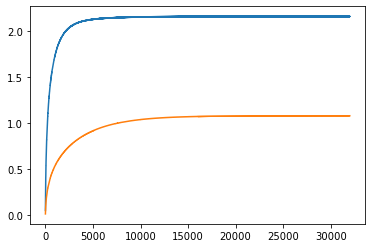

In [3]:
out = dict(**results[0])
for res in results[1:]:
    for k in res.keys():
        out[k] = jnp.concatenate((out[k], res[k]))
        
plt.plot(out['gradnorm1'])
plt.plot(out['gradnorm2'])

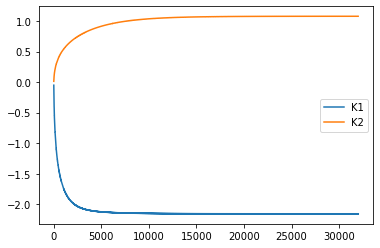

In [4]:
plt.plot(out['K1'].flatten(), label='K1')
plt.plot(out['K2'].flatten(), label='K2')
plt.legend()

In [5]:
out['K1'][-1],out['K2'][-1]

(DeviceArray([[-2.156344]], dtype=float32),
 DeviceArray([[1.077979]], dtype=float32))